In [20]:
from preamble import *

In [21]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

df = pd.read_csv('./data/j_lstm_data_v4.csv')
df.head()

,datetime,temperature,precipitation,wind_speed,humidity,atmospheric_pressure,snow,outflow,inflow,height,dayofmonth,dayofweek,quarter,month,year,dayofyear,week,hour,minute,second,is_weekend,is_holiday
0,2023-01-01 00:00:00,-0.9,0.0,1.4,72.0,1023.6,0.0,101.05,77.88,4.89,1,6,1,1,2023,1,52,0,0,0,1,1
1,2023-01-01 01:00:00,-1.3,0.0,1.5,74.0,1023.3,0.0,119.92,107.09,4.99,1,6,1,1,2023,1,52,1,0,0,1,1
2,2023-01-01 02:00:00,-1.7,0.0,1.4,75.0,1023.1,0.0,124.54,143.67,5.01,1,6,1,1,2023,1,52,2,0,0,1,1
3,2023-01-01 03:00:00,-2.0,0.0,1.2,77.0,1023.3,0.0,80.16,144.95,5.01,1,6,1,1,2023,1,52,3,0,0,1,1
4,2023-01-01 04:00:00,-2.0,0.0,1.7,79.0,1022.8,0.0,104.88,159.06,5.02,1,6,1,1,2023,1,52,4,0,0,1,1


In [22]:
df.shape

(15739, 22)

In [23]:
feature = df.drop('datetime', axis=1)
target = df['outflow'].values.reshape(-1, 1)

train_size = int(feature.shape[0] * 0.7)

trainset_feature = feature[:train_size]
trainset_target = target[:train_size]
testset_feature = feature[train_size:]
testset_target = target[train_size:]

In [5]:
from sklearn.preprocessing import MinMaxScaler

scaler_feature = MinMaxScaler()
train_feature_scaled = scaler_feature.fit_transform(trainset_feature)
test_feature_scaled = scaler_feature.transform(testset_feature)

scaler_target = MinMaxScaler()
train_target_scaled = scaler_target.fit_transform(trainset_target)
test_target_scaled = scaler_target.transform(testset_target)

In [6]:
import pickle

with open('./model/scaler_feature_lstm_j.pkl', 'wb') as f:
  pickle.dump(scaler_feature, f)
with open('./model/scaler_target_lstm_j.pkl', 'wb') as f:
  pickle.dump(scaler_target, f)

In [7]:
valid_size = int(train_feature_scaled.shape[0] * 0.9)

train_feature_scale = train_feature_scaled[:valid_size]
train_target_scale = train_target_scaled[:valid_size]
valid_feature_scaled = train_feature_scaled[valid_size:]
valid_target_scaled = train_target_scaled[valid_size:]

In [8]:
def split_dataset(data, target, seq_len, pred_len):
  X, y = [], []
  for i in range(data.shape[0] - (seq_len + pred_len) + 1):
    X.append(data[i:i + seq_len, :])
    y.append(target[i + seq_len:i + seq_len + pred_len])
  return np.array(X), np.array(y)

seq_len = 168
pred_len = 24

In [9]:
X_train, y_train = split_dataset(train_feature_scaled, train_target_scaled, seq_len, pred_len)
X_valid, y_valid = split_dataset(valid_feature_scaled, valid_target_scaled, seq_len, pred_len)
X_test, y_test = split_dataset(test_feature_scaled, test_target_scaled, seq_len, pred_len)

X_train_tensor, y_train_tensor = torch.tensor(X_train).float(), torch.tensor(y_train).float()
X_valid_tensor, y_valid_tensor = torch.tensor(X_valid).float(), torch.tensor(y_valid).float()
X_test_tensor, y_test_tensor = torch.tensor(X_test).float(), torch.tensor(y_test).float()

In [10]:
from torch.utils.data import DataLoader, TensorDataset

loader_train = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), shuffle=True,
                                           batch_size=128)
loader_valid = DataLoader(TensorDataset(X_valid_tensor, y_valid_tensor), shuffle=True,
                                           batch_size=128)
loader_test = DataLoader(TensorDataset(X_test_tensor, y_test_tensor), shuffle=False,
                                          batch_size=128)

In [11]:
class LSTMModel(nn.Module):
  def __init__(self, input_size, hidden_size, output_size):
    super(LSTMModel, self).__init__()
    self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
    self.fc = nn.Linear(hidden_size, output_size)

  def forward(self, x):
    lstm_out, _ = self.lstm(x)
    last_out = lstm_out[:, -1, :]
    out = self.fc(last_out)
    return out

input_size = 21
hidden_size = 50
output_size = 24
model = LSTMModel(input_size, hidden_size, output_size)


In [12]:
import torch.optim as optim

loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [13]:
def evaluate(model, valid_dataset, criterion, device):
  val_loss = 0
  model.eval()
  with torch.no_grad():
    for batch_X, batch_y in valid_dataset:
      batch_X, batch_y = batch_X.to(device), batch_y.to(device)
      logits =model(batch_X)
      batch_y = batch_y.view(batch_y.size(0), -1)
      loss = criterion(logits, batch_y)
      val_loss += loss.item()
  return val_loss

In [14]:
best_valid_loss = float('inf')
num_epochs = 300
loss_history = []
model.to(device)
for epoch in range(num_epochs):
  model.train()
  train_loss = 0.0
  for X_batch, y_batch in loader_train:
    X_batch, y_batch = X_batch.to(device), y_batch.to(device)

    out = model(X_batch)
    y_batch = y_batch.view(y_batch.size(0), -1)
    loss = loss_fn(out, y_batch)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    train_loss += loss.item()

  loss_history.append(train_loss / len(loader_train.dataset))
  valid_loss = evaluate(model, loader_valid, loss_fn, device)
  print(f'Epoch : {epoch + 1} / {num_epochs}')
  print(f'Train Loss : {train_loss}')
  print(f'Valid Loss : {valid_loss}')
  if valid_loss < best_valid_loss:
    best_valid_loss = valid_loss
    torch.save(model.state_dict(), './model/best_lstm_checkpoint_j.pt')

Epoch : 1 / 300
Train Loss : 4.846976768225431
Valid Loss : 0.31220174953341484
Epoch : 2 / 300
Train Loss : 2.808354500681162
Valid Loss : 0.22887207567691803
Epoch : 3 / 300
Train Loss : 2.158750142902136
Valid Loss : 0.1762344352900982
Epoch : 4 / 300
Train Loss : 1.6220779698342085
Valid Loss : 0.13499855529516935
Epoch : 5 / 300
Train Loss : 1.5411181673407555
Valid Loss : 0.13077967055141926
Epoch : 6 / 300
Train Loss : 1.5223150867968798
Valid Loss : 0.1302295634523034
Epoch : 7 / 300
Train Loss : 1.516402494162321
Valid Loss : 0.12659501191228628
Epoch : 8 / 300
Train Loss : 1.5034131594002247
Valid Loss : 0.12704330682754517
Epoch : 9 / 300
Train Loss : 1.4964273422956467
Valid Loss : 0.12607323843985796
Epoch : 10 / 300
Train Loss : 1.4894536528736353
Valid Loss : 0.1244921050965786
Epoch : 11 / 300
Train Loss : 1.4843044616281986
Valid Loss : 0.12422429490834475
Epoch : 12 / 300
Train Loss : 1.473506223410368
Valid Loss : 0.12248272448778152
Epoch : 13 / 300
Train Loss : 1.4

In [15]:
model.load_state_dict(torch.load('./model/best_lstm_checkpoint_j.pt'))
model.to(device)

C:\Users\user\AppData\Local\Temp\ipykernel_11368\3925003370.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('./model/best_lstm_checkpoin

LSTMModel(
  (lstm): LSTM(21, 50, batch_first=True)
  (fc): Linear(in_features=50, out_features=24, bias=True)
)

In [16]:
model.eval()

y_pred_list = []
with torch.no_grad():
  for X_batch, _ in loader_test:
    X_batch = X_batch.to(device)
    y_pred = model(X_batch).cpu().numpy()
    y_pred_list.append(y_pred)

y_pred = np.concatenate(y_pred_list, axis=0)

In [17]:
from sklearn.metrics import mean_squared_error, r2_score

y_test_ori = scaler_target.inverse_transform(y_test.reshape(-1, pred_len))
y_pred_ori = scaler_target.inverse_transform(y_pred)

mse = mean_squared_error(y_test.reshape(-1, pred_len), y_pred)
mse_ori = mean_squared_error(y_test_ori, y_pred_ori)
rmse = np.sqrt(mse)
rmse_ori = np.sqrt(mse_ori)
r2 = r2_score(y_test.reshape(-1, pred_len), y_pred)
print(f'RMSE : {rmse}, RMSE_ORI : {rmse_ori} R-value : {r2}')

RMSE : 0.16760427471571876, RMSE_ORI : 45.1676761151494 R-value : 0.32742590908164365


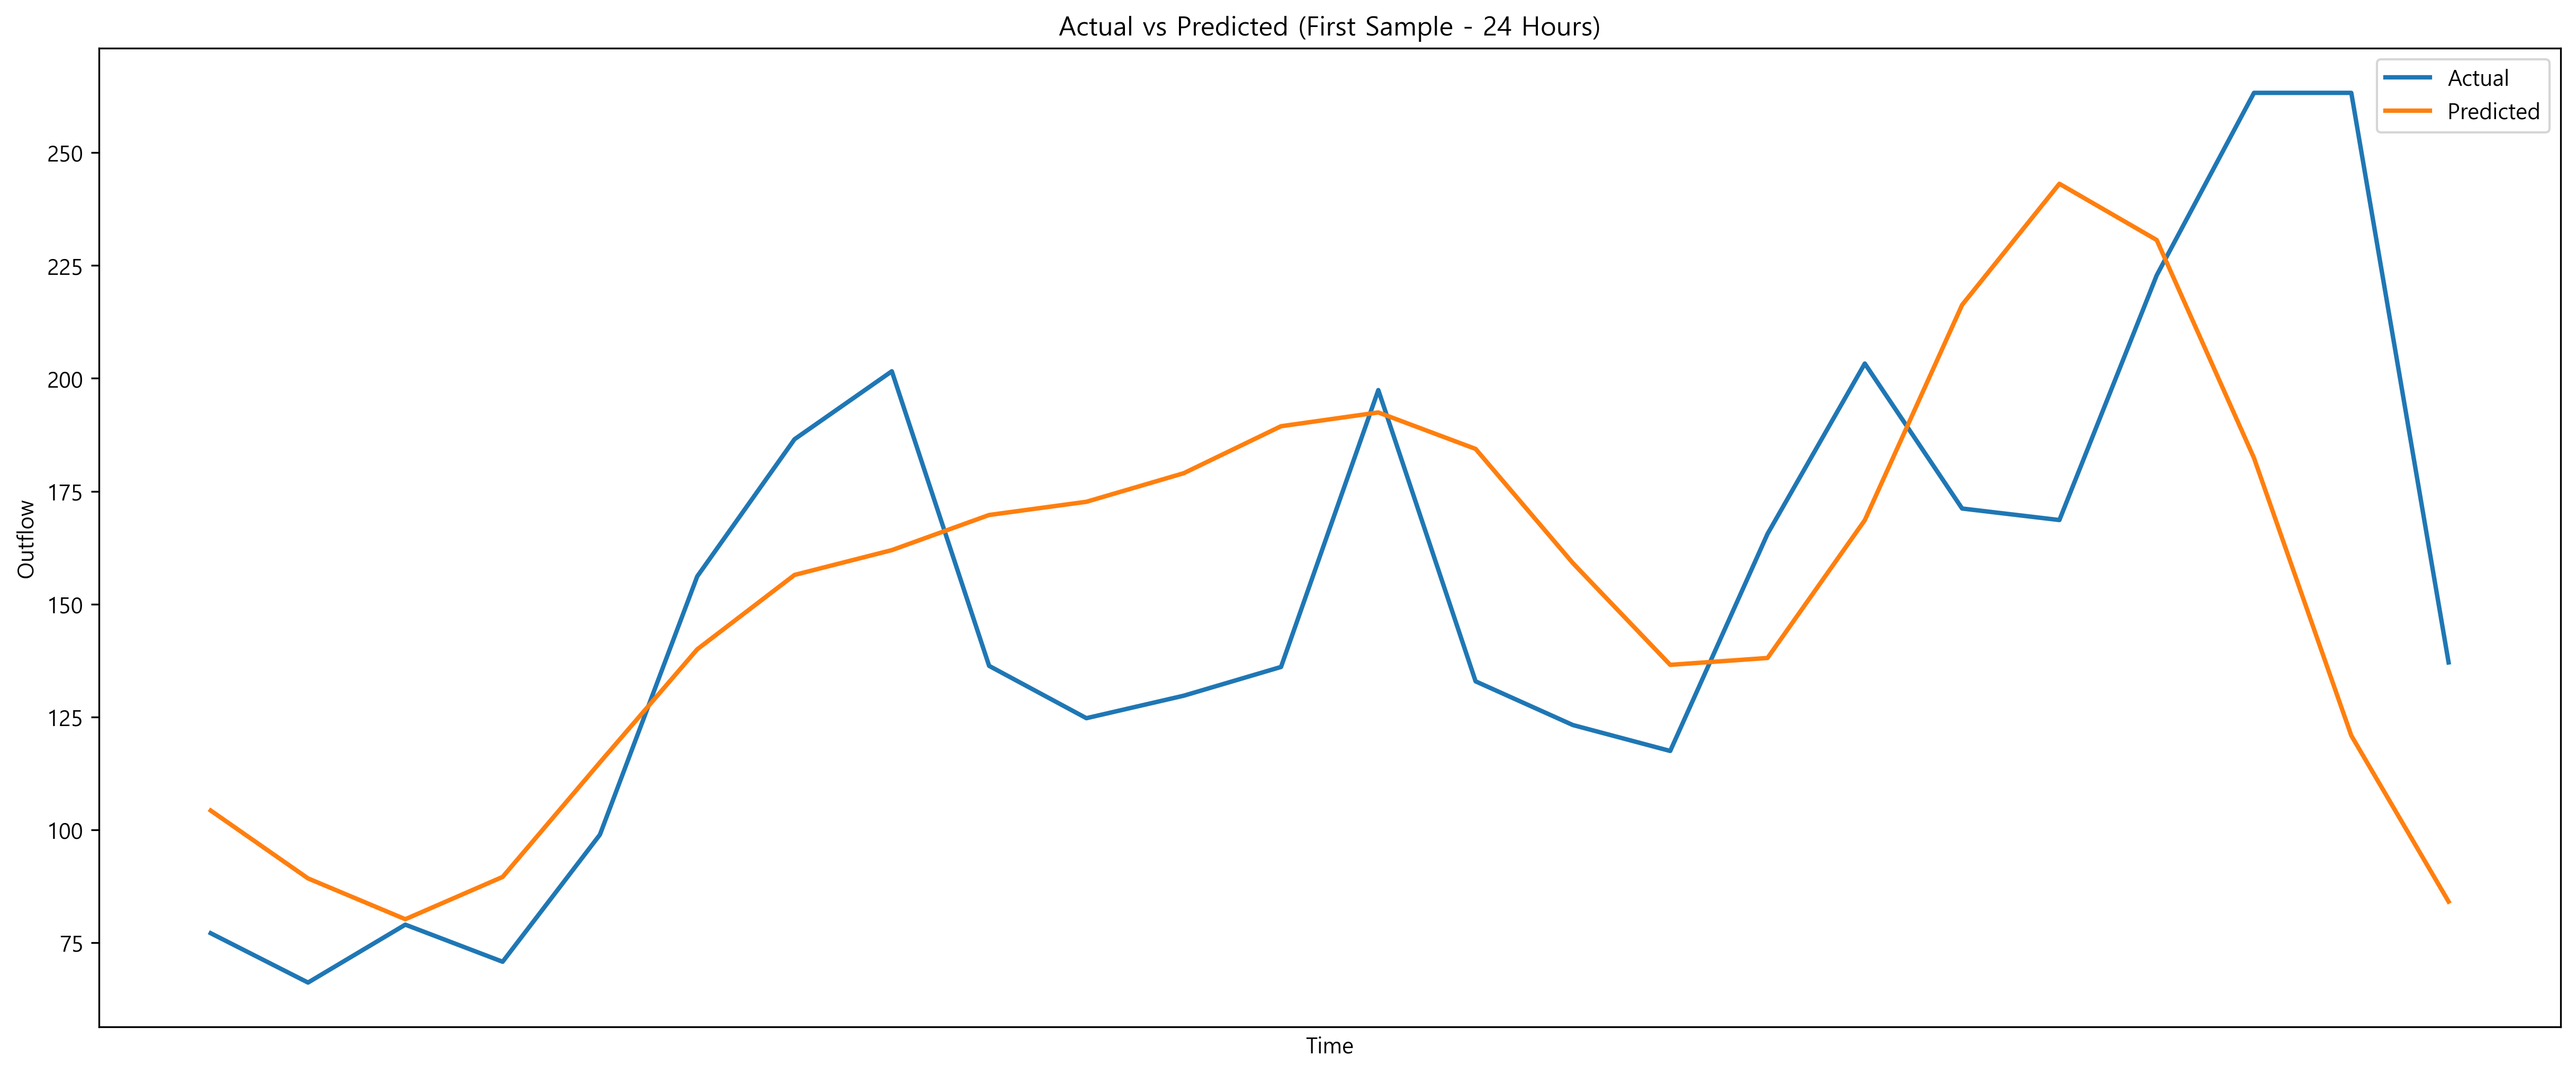

In [18]:
# 예측 결과 시각화 (첫 번째 샘플의 24시간 예측)
plt.figure(figsize=(20, 8))
plt.xticks([])

actual_data = y_test_ori[0]
predicted_data = y_pred_ori[0]

time_index = df.index[train_size + seq_len:train_size + seq_len + pred_len]

plt.plot(time_index, actual_data, label='Actual')
plt.plot(time_index, predicted_data, label='Predicted')
plt.legend()
plt.title('Actual vs Predicted (First Sample - 24 Hours)')
plt.xlabel('Time')
plt.ylabel('Outflow')
plt.show()

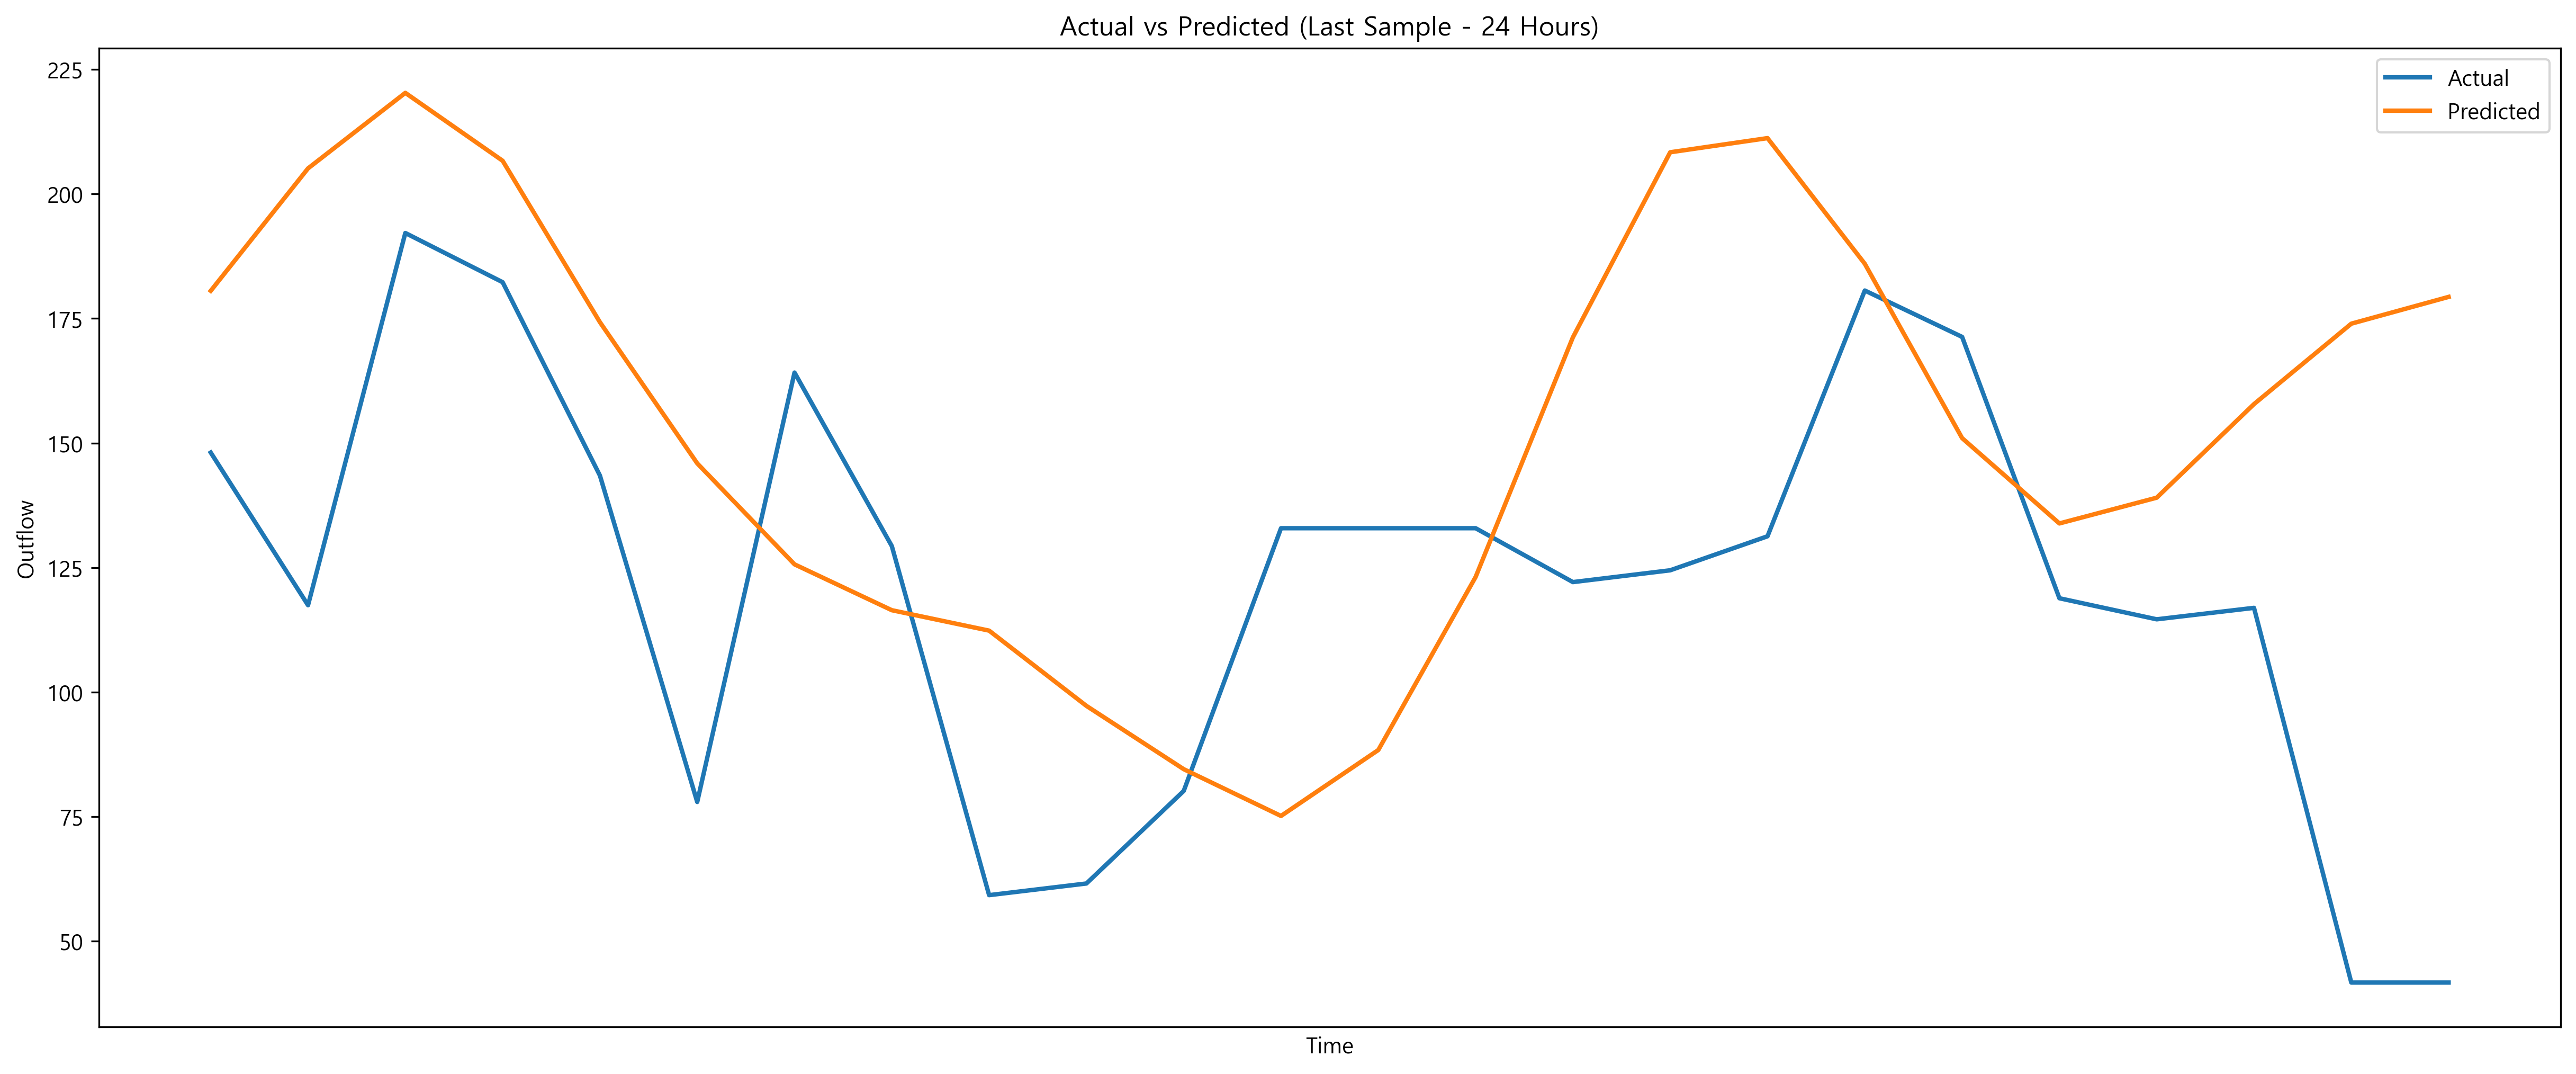

In [19]:
plt.figure(figsize=(20, 8))
plt.xticks([])

actual_data = y_test_ori[-1]
predicted_data = y_pred_ori[-1]

start_index = train_size + seq_len + (len(y_test)-1)
time_index = df.index[start_index:start_index + pred_len]


plt.plot(time_index, actual_data, label='Actual')
plt.plot(time_index, predicted_data, label='Predicted')
plt.legend()
plt.title('Actual vs Predicted (Last Sample - 24 Hours)')
plt.xlabel('Time')
plt.ylabel('Outflow')
plt.show()